In [1]:
import matplotlib.pyplot as plt
import torch
import numpy as np
import pandas as pd
import scienceplots
import seaborn as sns
from modeling_grad import SwavMolecule, ConformationDataset
from torch_geometric.loader import DataLoader
from tqdm import tqdm
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore', '.*TypedStorage is deprecated.*')

In [2]:
# load the data
PATH = r"/home/bobo/graduation/data/pku_val/data"
atom_inputs = torch.load(f"{PATH}/atom_inputs.pt")
aa_inputs = torch.load(f"{PATH}/aa_inputs.pt")
edge_index = torch.load(f"{PATH}/edge_index.pt")
cartesian_coord = torch.load(f"{PATH}/pt_coords.pt")
cartesian_coord = (cartesian_coord 
                   - cartesian_coord.sum(dim=1, keepdim=True) / cartesian_coord.shape[1])

dataset = ConformationDataset(
    cartesian_coord, atom_inputs, aa_inputs, edge_index)

In [3]:
num_atoms = dataset[0][0].unique().size(0)
num_aa = dataset[0][1].unique().size(0)
num_prototypes = 4
model = SwavMolecule(
    num_atom=num_atoms,
    num_aa=num_aa,
    coord_inputs_dim=3,
    node_dim=64,
    edge_attr_dim=64,
    global_attr_dim=64,
    dropout_prob=0.0,
    num_layers=12,
    num_prototypes=num_prototypes,
    use_projector=True,
    proj_hidden_dim=128,
    proj_output_dim=8,
    norm_type="graphnorm",
)

ROOT = "./"
ckpt_path = ROOT + "swav_mole.pth"
model.load_state_dict(torch.load(ckpt_path)['model'])

<All keys matched successfully>

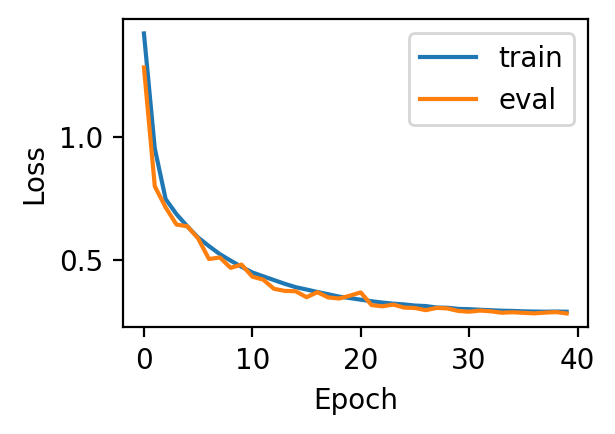

In [4]:
plt.figure(figsize=(3, 2), dpi=200)
plt.plot(np.load(ROOT + 'loss.npy'), label='train')
plt.plot(np.load(ROOT + 'eval_loss.npy'), label='eval')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [4]:
if torch.cuda.is_available():
    device = 'cuda'
    model = model.cuda()
    print('using cuda')
else:
    device = 'cpu'
    print('using cpu')

using cuda


In [5]:
batch_size = 512
temperature = 0.25
dataloader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

In [6]:
cluster_all = torch.empty((0))
u_all = torch.empty((0, 8))

for batch in tqdm(dataloader, total=len(dataloader)):
    model.eval()
    atom_id, amino_acids_id, data_batch = batch
    batch_size = atom_id.size(0)
    edge_index = data_batch.edge_index
    x = data_batch.x
    with torch.no_grad():
        res = model(
            x.to(device), 
            atom_id.to(device), 
            amino_acids_id.to(device), 
            edge_index.to(device)
        )
        scores = res['scores'].cpu()
        u = res['features'].cpu()
        z = u / u.norm(dim=1, keepdim=True, p=2)
        p = torch.nn.functional.softmax(scores / temperature, dim=-1)
        cluster = torch.argmax(p, dim=1)
        cluster_all = torch.concat((cluster_all, cluster), dim=0)
        u_all = torch.concat((u_all, u), dim=0)

100%|██████████| 977/977 [01:16<00:00, 12.79it/s]


In [8]:
np.save(ROOT + 'cluster.npy', cluster_all.numpy())
# np.save(ROOT + 'z.npy', z_all.numpy())

In [10]:
tors = pd.read_csv('../../tor_angles.traj', sep='    ', header=None, index_col=0)
tors.columns = ['phi', 'psi']
tors.index.name = 'frame'
tors['cluster'] = np.load(ROOT + 'cluster.npy')
# tors['cluster'] = cluster_all.numpy()

/tmp/ipykernel_6164/981937332.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  tors = pd.read_csv('../../tor_angles.traj', sep='    ', header=None, index_col=0)


In [10]:
for cluster, frames in tors.groupby('cluster').groups.items():
    print(f'{cluster}: {len(frames)}')

0.0: 127264
1.0: 85502
2.0: 105251
3.0: 181983


Text(0, 0.5, '$\\psi (degree)$')

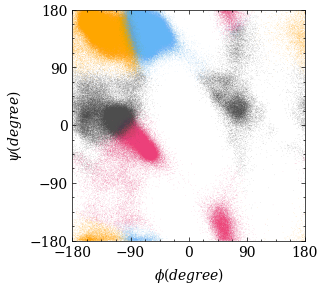

In [92]:
plt.style.use(['science', 'no-latex'])
fig, ax = plt.subplots(figsize=(3, 3), dpi=100)
ax.scatter(tors['phi'], tors['psi'],
           edgecolors='none', alpha=0.5,
           s=0.1, c=tors['cluster'], cmap=cmap, norm=norm)
ax.autoscale(tight=True)
ax.set_xticks([-180, -90, 0 , 90 ,180])
ax.set_yticks([-180, -90, 0 , 90 ,180])
ax.set_xlabel(r"$\phi (degree)$")
ax.set_ylabel(r"$\psi (degree)$")
# fig.savefig(ROOT + 'cluster_4.png', dpi=600, bbox_inches='tight')

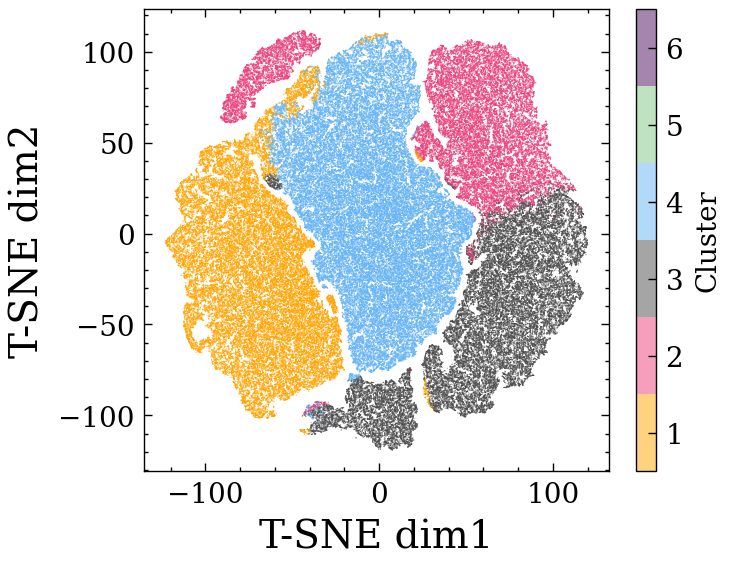

In [225]:
import matplotlib.colors as mcolors
from matplotlib import gridspec 

with plt.style.context(['science', 'no-latex']):
    fig = plt.figure(figsize=(11 * 0.3, 10 * 0.3), dpi=200)
    grid = gridspec.GridSpec(20, 22)
    ax = fig.add_subplot(grid[:,:20])
    ax2 = fig.add_subplot(grid[:,21])
    colors = ['#FFA600', '#EC407A', '#4D4D4D', '#64B5F6', '#81C784', '#4C0B5F']

    cmap = mcolors.ListedColormap(colors)
    norm = mcolors.Normalize(vmin=0, vmax=6)
    
    sct = ax.scatter(z_2d[:,0], z_2d[:,1], c=cluster_all.numpy(),
               alpha=0.5, edgecolors='none',
               linewidths=0.1, s=0.1, cmap=cmap, norm=norm)
    
    ax.autoscale()
    ax.set_xlabel(r"T-SNE dim1", fontsize=14)
    ax.set_ylabel(r"T-SNE dim2", fontsize=14)
    cbar = fig.colorbar(mappable=sct, cax=ax2)
    cbar.set_label('Cluster')
    cbar.set_ticks(np.arange(1, 7, 1) - 0.5)
    cbar.set_ticklabels(np.arange(1, 7, 1))
    cbar.minorticks_off()
    
    fig.savefig('tsne-25.png', dpi=600, bbox_inches='tight')

In [11]:
kmeans = KMeans(n_clusters=6, 
                random_state=1919, 
                n_init='auto', 
                algorithm='elkan').fit(u_all.numpy())

In [12]:
kmeans.labels_

array([1, 1, 1, ..., 4, 4, 1], dtype=int32)

In [213]:
def change_color(npar, a, b):
    npar = np.where(npar == a, -1, npar)
    npar = np.where(npar == b, -2, npar)
    npar = np.where(npar == -1, b, npar)
    npar = np.where(npar == -2, a, npar)
    return npar

In [220]:
clrs = kmeans.labels_
clrs = change_color(clrs, 0, 2)
clrs = change_color(clrs, 1, 4)
clrs = change_color(clrs, 2, 3)
clrs = change_color(clrs, 2, 4)

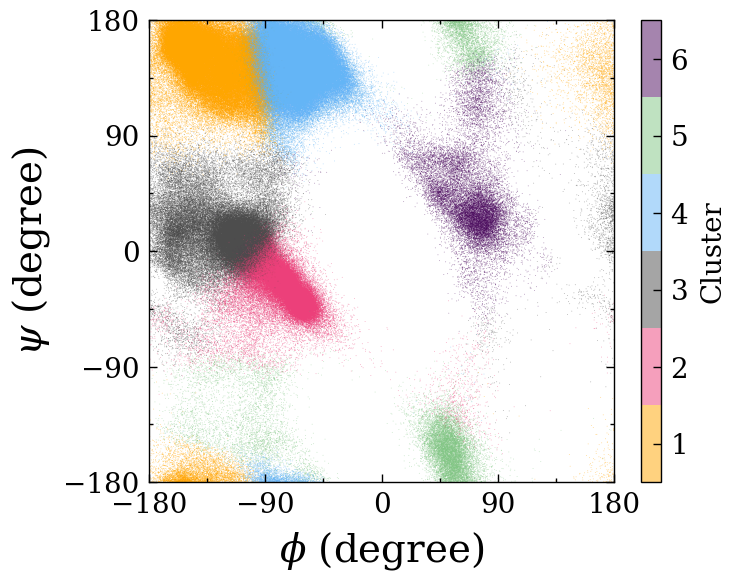

In [223]:
with plt.style.context(['science', 'no-latex']):
    fig = plt.figure(figsize=(11 * 0.3, 10 * 0.3), dpi=200)
    grid = gridspec.GridSpec(20, 22)
    ax = fig.add_subplot(grid[:,:20])
    ax2 = fig.add_subplot(grid[:,21])
    colors = ['#FFA600', '#EC407A', '#4D4D4D', '#64B5F6', '#81C784', '#4C0B5F']

    cmap = mcolors.ListedColormap(colors)
    norm = mcolors.Normalize(vmin=0, vmax=6)
    
    sct = ax.scatter(tors['phi'], tors['psi'], 
                     c=clrs,
                     alpha=0.5, edgecolors='none',
                     s=0.1, cmap=cmap, norm=norm)
    
    ax.autoscale(tight=True)
    ax.set_xticks([-180, -90, 0 , 90 ,180])
    ax.set_xticks([-135, -45, 45, 135], minor=True)
    ax.set_yticks([-180, -90, 0 , 90 ,180])
    ax.set_yticks([-135, -45, 45, 135], minor=True)
    ax.set_xlabel(r"$\phi$ (degree)", fontsize=14)
    ax.set_ylabel(r"$\psi$ (degree)", fontsize=14)
    cbar = fig.colorbar(mappable=sct, cax=ax2)
    cbar.set_label('Cluster')
    cbar.set_ticks(np.arange(1, 7, 1) - 0.5)
    cbar.set_ticklabels(np.arange(1, 7, 1))
    cbar.minorticks_off()
    
    fig.savefig('kmeans-6.png', dpi=600, bbox_inches='tight')